In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

In [91]:
test = pd.read_csv('datasets/test_forest.csv')
train = pd.read_csv('datasets/train_forest.csv')
train.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
#On garde en copie les datasets originelles en memoire au cas ou on a besoin plus tard
train_original = train.copy()
test_original = test.copy()

## Exploration des données 
Dans cette partie nous regarderons nos données, matrice de correlation, distributions des classes et études des variables de sol 

In [7]:
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2909,28,18,182,58,1350,210,197,117,2160,...,0,0,0,0,0,0,0,0,0,2
1,2757,334,30,212,83,1384,137,184,177,1570,...,0,0,0,0,0,0,0,0,0,2
2,3283,248,4,150,15,5601,211,243,170,892,...,0,0,0,0,0,0,1,0,0,1
3,3019,330,14,541,-101,1811,186,222,175,2154,...,0,0,0,0,0,0,0,0,0,2
4,3039,340,20,474,74,3407,175,207,169,1879,...,0,0,0,0,0,0,0,1,0,1


On peut commencer a remarquer que nous disposons de beaucoup de variables binaires pour les types de sol que nous pourrons chercher a reduire

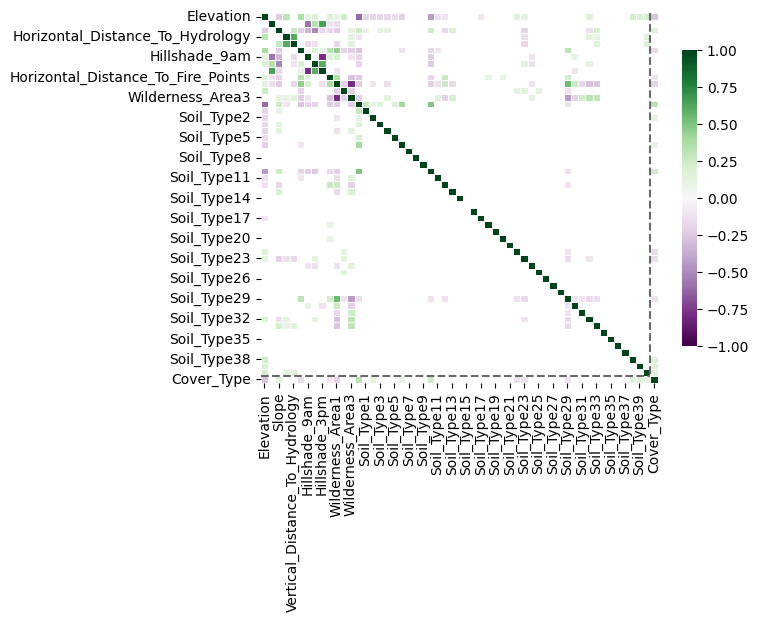

In [5]:

df = train.copy()
# Calcul de la matrice de corrélation
corr_matrix = df.corr()

# Création d'un masque pour les faibles corrélations (par exemple, valeurs proches de zéro)
mask = np.abs(corr_matrix) < 0.1  # Ajuste le seuil selon le niveau de corrélation "faible" que tu souhaites

# Choix de la palette de couleurs
palette = 'PRGn'

fig, ax = plt.subplots(1, 1)
sns.heatmap(corr_matrix, mask=mask, annot=False, vmin=-1, vmax=1, cmap=palette, ax=ax, 
            cbar_kws={"shrink": .8}, linewidths=.5, linecolor="white")

# Ajustement des lignes pour les variables explicatives
nvarexp = df.shape[1] - 1
ax.plot([0, nvarexp], [nvarexp, nvarexp], linestyle='--', color='dimgray')
ax.plot([nvarexp, nvarexp], [0, nvarexp], linestyle='--', color='dimgray')

plt.show()


Les variables ne semblent pas au premier abord specialement correle entre elle, on commence donc notre étude sans en enlever. On peut également remarquer que pour la pluspart 
la variable objectif n'est pas correlé aux autres. Cela ne veut pas dire qu'il n'y a pas de lien mais qu'elles ne sont pas relié de maniere lineaire, cela nous indique que des 
modeles utilisant des arbres de decisions seraient plus aptes a capter ce genre de relations que des modeles lineaires comme la regression logisitque. 

/tmp/ipykernel_21648/2449047786.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_data.index, y=count_data.values, palette="viridis")


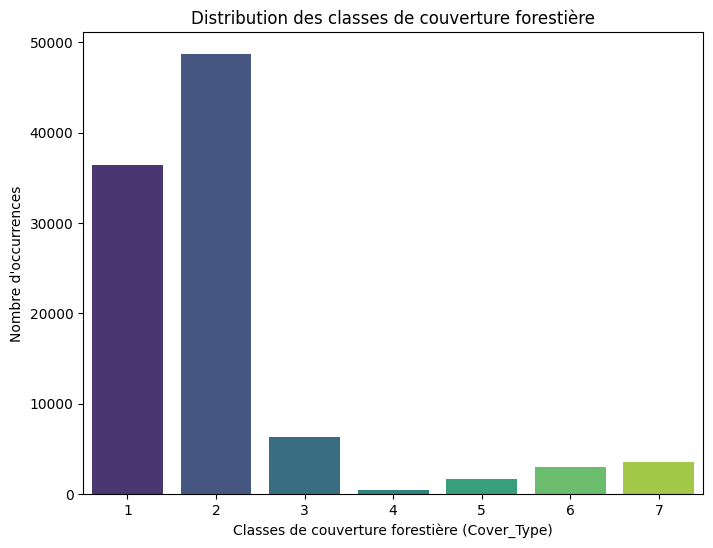

In [6]:

# Compter les occurrences de chaque catégorie
count_data = df['Cover_Type'].value_counts()

# Tracer un graphique à barres
plt.figure(figsize=(8, 6))
sns.barplot(x=count_data.index, y=count_data.values, palette="viridis")
plt.xlabel("Classes de couverture forestière (Cover_Type)")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des classes de couverture forestière")
plt.show()


Certaines classes sont sous representé par rapport aux autres, classe 4,5,6 et 7,3 par rapport a 1 et 2 on pourra penser a faire de l'over fitting ou de l'underfitting

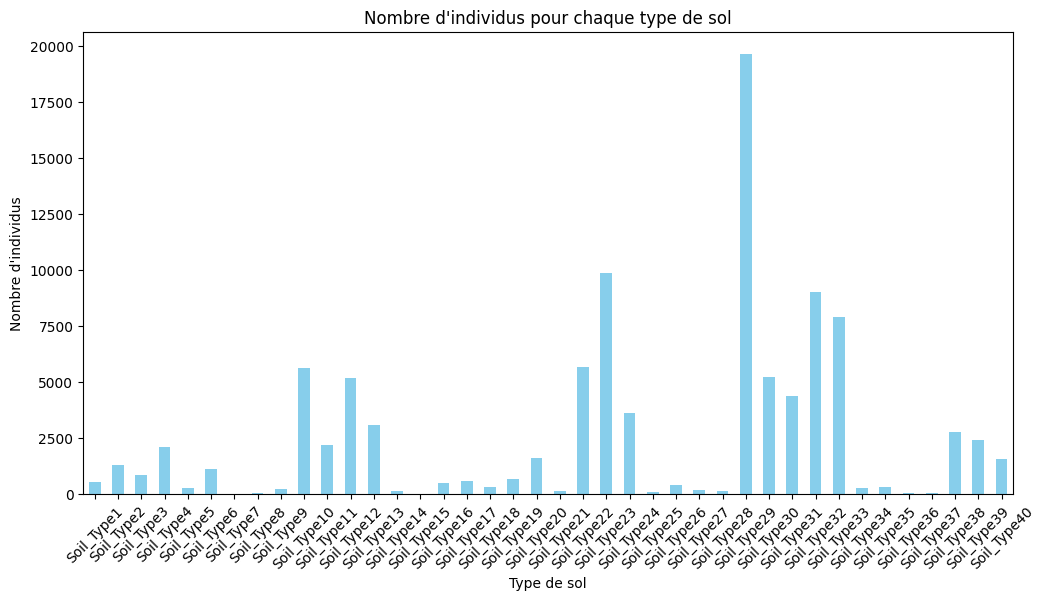

In [8]:
soil_columns = [col for col in df.columns if 'Soil_Type' in col]

# Calculer le nombre d'individus pour chaque type de sol
soil_counts = df[soil_columns].sum()

# Créer un histogramme
plt.figure(figsize=(12, 6))
soil_counts.plot(kind='bar', color='skyblue')
plt.title("Nombre d'individus pour chaque type de sol")
plt.xlabel("Type de sol")
plt.ylabel("Nombre d'individus")
plt.xticks(rotation=45)
plt.show()

On peut voir que certaines variable soil type on très peu d'individu, ce qui peut poser probleme si il y a une faible diversité de cover type parmis ceux la. 

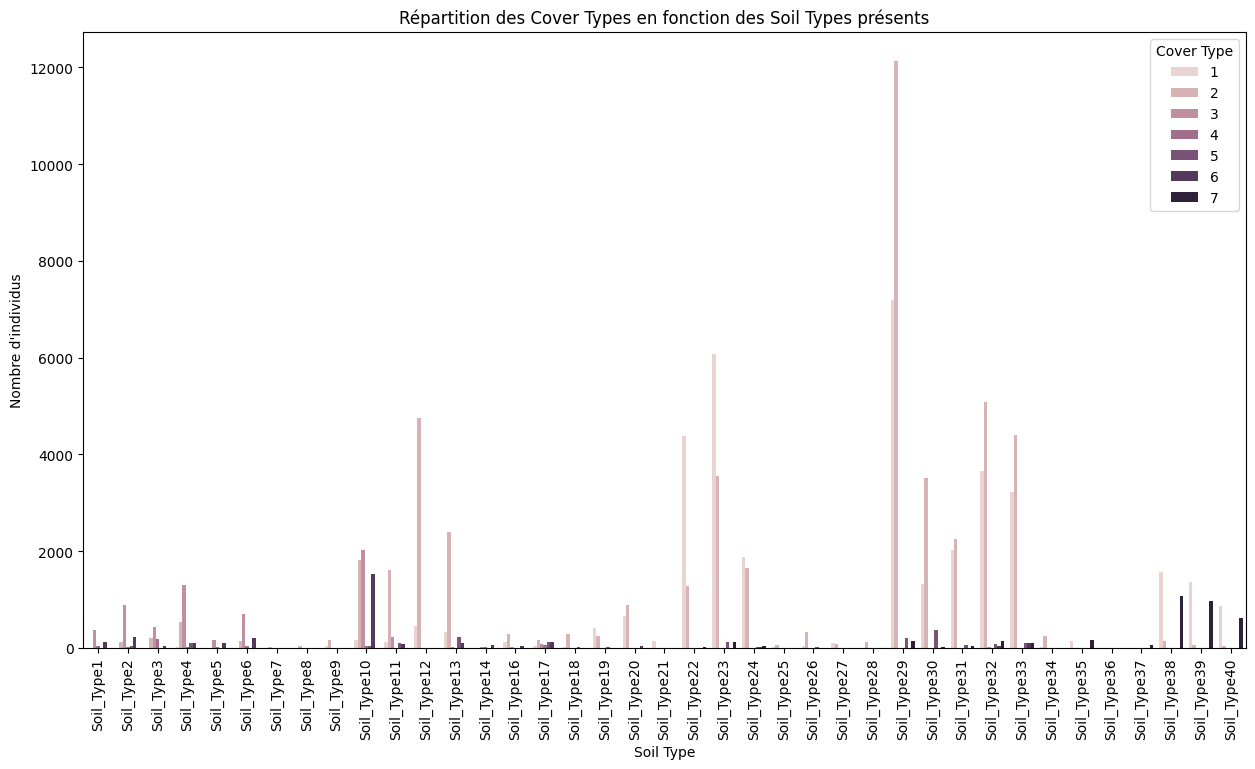

In [57]:
df_melted = df.melt(id_vars='Cover_Type', value_vars=[col for col in df.columns if 'Soil_Type' in col],
                    var_name='Soil_Type', value_name='Presence')

# Garder uniquement les lignes où Soil_Type est présent (valeur = 1)
df_melted = df_melted[df_melted['Presence'] == 1]

# Visualisation
plt.figure(figsize=(15, 8))
sns.countplot(data=df_melted, x='Soil_Type', hue='Cover_Type')
plt.title("Répartition des Cover Types en fonction des Soil Types présents")
plt.xlabel("Soil Type")
plt.ylabel("Nombre d'individus")
plt.xticks(rotation=90)
plt.legend(title="Cover Type")
plt.show()


Certaines variable de soil on très peu de diversité, on observe également des pics d'individu pour certains type de sol de meme cover type. On pourrait potentiellement penser a 
supprimer les variables avec peu d'individu

## Modification des données 
Dans cette partie nous proposerons plusieurs modifications sur le dataframe initiale, rajout de variable, enlever certaines variables, overfitting et underfitting. 

In [39]:
df_change = df.copy()
# On rajoute le cos et sin pour les variables qui s'expriment en degré, on rajoute elevation relative car c'est une va qui peut prendre de grande valeurs,
#Nous avons également tester le fait de mettre au carré certaines va de distances pour augmenter leur importance et au contraire de passer au log. 

df_change['Elevation_Relative'] = df_change['Elevation'] - df_change['Elevation'].mean()
df_change['Elevation_Standardized'] = (df_change['Elevation'] - df_change['Elevation'].mean()) / df_change['Elevation'].std()

df_change['Aspect_sin'] = np.sin(np.radians(df_change['Aspect']))
df_change['Aspect_cos'] = np.cos(np.radians(df_change['Aspect']))

df_change['Slope_sin'] = np.sin(np.radians(df_change['Slope']))
df_change['Slope_cos'] = np.cos(np.radians(df_change['Slope']))

df_change['Horizontal_Distance_To_Roadways_2'] = df_change['Horizontal_Distance_To_Roadways']**2
df_change['Horizontal_Distance_To_Fire_Points_2'] = df_change['Horizontal_Distance_To_Fire_Points']**2
df_change['Horizontal_Distance_To_Hydrology_2'] = df_change['Horizontal_Distance_To_Hydrology']**2
df_change['Vertical_Distance_To_Hydrology_2'] = df_change['Vertical_Distance_To_Hydrology']**2




In [55]:
#tentative de regrouper les types de sol 
 #Fonction pour regrouper les types de sol en groupes
def regroup_soil_types(row):
    soil_groups = {
        'Affleurement_rocheux': 0,
        'Famille_Leighcan': 0,
        'Pierreux_Caillouteux': 0,
        'Complexes_Cry': 0,
        'Sols_hydriques_humides': 0,
        'Autres': 0
    }

    # Définir les règles pour chaque groupe
    if row['Soil_Type1'] == 1 or row['Soil_Type3'] == 1 or row['Soil_Type4'] == 1 or row['Soil_Type5'] == 1 or row['Soil_Type6'] == 1 or row['Soil_Type10'] == 1 or row['Soil_Type11'] == 1 or row['Soil_Type13'] == 1 or row['Soil_Type27'] == 1 or row['Soil_Type28'] == 1 or row['Soil_Type32'] == 1 or row['Soil_Type33'] == 1 or row['Soil_Type37'] == 1:
        soil_groups['Affleurement_rocheux'] = 1

    if row['Soil_Type22'] == 1 or row['Soil_Type23'] == 1 or row['Soil_Type24'] == 1 or row['Soil_Type25'] == 1 or row['Soil_Type27'] == 1 or row['Soil_Type29'] == 1 or row['Soil_Type31'] == 1 or row['Soil_Type33'] == 1:
        soil_groups['Famille_Leighcan'] = 1

    if row['Soil_Type9'] == 1 or row['Soil_Type22'] == 1 or row['Soil_Type23'] == 1 or row['Soil_Type24'] == 1 or row['Soil_Type25'] == 1 or row['Soil_Type27'] == 1 or row['Soil_Type28'] == 1 or row['Soil_Type29'] == 1 or row['Soil_Type30'] == 1 or row['Soil_Type31'] == 1 or row['Soil_Type32'] == 1 or row['Soil_Type36'] == 1 or row['Soil_Type37'] == 1 or row['Soil_Type38'] == 1 or row['Soil_Type39'] == 1:
        soil_groups['Pierreux_Caillouteux'] = 1

    if row['Soil_Type16'] == 1 or row['Soil_Type19'] == 1 or row['Soil_Type20'] == 1 or row['Soil_Type34'] == 1 or row['Soil_Type35'] == 1 or row['Soil_Type37'] == 1 or row['Soil_Type39'] == 1:
        soil_groups['Complexes_Cry'] = 1

    if row['Soil_Type6'] == 1 or row['Soil_Type14'] == 1 or row['Soil_Type19'] == 1 or row['Soil_Type20'] == 1 or row['Soil_Type21'] == 1:
        soil_groups['Sols_hydriques_humides'] = 1

    # Sinon, mettre 'Autres'
    soil_groups['Autres'] = 1 if not any(soil_groups.values()) else 0

    return pd.Series(soil_groups)

# Appliquer la fonction à chaque ligne du dataframe pour créer les nouvelles colonnes
df_new = df_change.copy()
df_new_ = df_new.apply(regroup_soil_types, axis=1)

# Ajouter ces nouvelles colonnes au dataframe original
df_change_2 = pd.concat([df_new, df_new_], axis=1)


In [58]:
#on retire les types de soil avec peu d'individu
# Compter les occurrences de chaque Soil_Type
soil_counts = df_melted['Soil_Type'].value_counts()

# Filtrer les Soil_Type avec moins de 100 occurrences
rare_soil_types = soil_counts[soil_counts < 200].index.tolist()
df_change_2 = df_change_2.drop(columns=rare_soil_types)

In [59]:
#on retire les variables peu representative pour xgboost 
# Liste des variables à supprimer
df_change_xg = df_change_2.copy()
variables_a_retirer = [
    'Soil_Type15', 'Elevation_Relative', 'Elevation_Standardized', 
    'Slope_sin', 'Slope_cos', 'Horizontal_Distance_To_Roadways_2', 
    'Horizontal_Distance_To_Fire_Points_2', 'Horizontal_Distance_To_Hydrology_2', 
    'Soil_Type8', 'Soil_Type7', 'Aspect_sin', 'Slope', 'Hillshade_3pm'
]

# Vérifier et retirer les colonnes si elles sont présentes dans le dataframe
df_change_xg = df_change_xg.drop(columns=[col for col in variables_a_retirer if col in df_change_xg.columns])

In [77]:
variables_a_retirer = [
    'Soil_Type15', 'Elevation_Relative', 'Elevation_Standardized', 
    'Slope_sin', 'Slope_cos', 'Horizontal_Distance_To_Roadways_2', 
    'Horizontal_Distance_To_Fire_Points_2', 'Horizontal_Distance_To_Hydrology_2', 
    'Soil_Type8', 'Soil_Type7', 'Aspect_sin', 'Slope', 'Hillshade_3pm'
]

### on met les memes changement dans le dataframe de test

In [93]:
df_new_ = test.apply(regroup_soil_types, axis=1)

# Ajouter ces nouvelles colonnes au dataframe original
test = pd.concat([test, df_new_], axis=1)

In [92]:
# Calculs sur la variable 'Elevation'
test['Elevation_Relative'] = test['Elevation'] - test['Elevation'].mean()
test['Elevation_Standardized'] = (test['Elevation'] - test['Elevation'].mean()) / test['Elevation'].std()

# Calculs sur la variable 'Aspect' avec sin et cos
test['Aspect_sin'] = np.sin(np.radians(test['Aspect']))
test['Aspect_cos'] = np.cos(np.radians(test['Aspect']))

# Calculs sur la variable 'Slope' avec sin et cos
test['Slope_sin'] = np.sin(np.radians(test['Slope']))
test['Slope_cos'] = np.cos(np.radians(test['Slope']))

# Calculs de distances élevées au carré
test['Horizontal_Distance_To_Roadways_2'] = test['Horizontal_Distance_To_Roadways']**2
test['Horizontal_Distance_To_Fire_Points_2'] = test['Horizontal_Distance_To_Fire_Points']**2
test['Horizontal_Distance_To_Hydrology_2'] = test['Horizontal_Distance_To_Hydrology']**2
test['Vertical_Distance_To_Hydrology_2'] = test['Vertical_Distance_To_Hydrology']**2


In [95]:
test = test.drop(columns=[col for col in variables_a_retirer if col in test.columns])


In [94]:
test = test.drop(columns=rare_soil_types)

# Model fitting

## Model fitting premiere etude (sans changement data train)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [8]:

X = df.drop('Cover_Type', axis=1)  # Variables explicatives
y = df['Cover_Type']  # Variable cible (Cover_Type avec 7 classes)

# Division avec stratification pour préserver les proportions des 7 classes dans train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Regression logistique


In [9]:
# Initialisation du modèle
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Entraînement du modèle
logreg.fit(X_train, y_train)

# Prédiction sur l'échantillon de test
y_pred_test = logreg.predict(X_test)

# Prédiction sur l'échantillon d'entraînement
y_pred_train = logreg.predict(X_train)

# Évaluation pour les données de test
print("Régression Logistique - Classification Report (Test):")
print(classification_report(y_test, y_pred_test))

# Évaluation pour les données d'entraînement
print("Régression Logistique - Classification Report (Train):")
print(classification_report(y_train, y_pred_train))



Régression Logistique - Classification Report (Test):
              precision    recall  f1-score   support

           1       0.67      0.69      0.68      7282
           2       0.70      0.81      0.75      9735
           3       0.62      0.62      0.62      1255
           4       0.64      0.19      0.30        94
           5       0.00      0.00      0.00       327
           6       0.14      0.02      0.03       593
           7       0.32      0.02      0.03       714

    accuracy                           0.68     20000
   macro avg       0.44      0.33      0.34     20000
weighted avg       0.65      0.68      0.66     20000

Régression Logistique - Classification Report (Train):
              precision    recall  f1-score   support

           1       0.67      0.70      0.69     29128
           2       0.71      0.80      0.75     38941
           3       0.62      0.64      0.63      5018
           4       0.48      0.16      0.24       377
           5       0.00

/home/sam/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 

### Arbre de decision

In [11]:

# Initialisation du modèle
dtree = DecisionTreeClassifier(random_state=42)

# Entraînement du modèle
dtree.fit(X_train, y_train)

# Prédiction
y_pred_dtree_test = dtree.predict(X_test)

y_pred_dtree_train = dtree.predict(X_train)


# Évaluation
print("Arbre de Décision - Classification Report (Test):")
print(classification_report(y_test, y_pred_dtree_test))

print("Arbre de Décision - Classification Report (Train):")
print(classification_report(y_train, y_pred_dtree_train))


Arbre de Décision - Classification Report (Test):
              precision    recall  f1-score   support

           1       0.86      0.86      0.86      7282
           2       0.88      0.89      0.88      9735
           3       0.86      0.84      0.85      1255
           4       0.72      0.74      0.73        94
           5       0.64      0.65      0.64       327
           6       0.72      0.72      0.72       593
           7       0.86      0.86      0.86       714

    accuracy                           0.86     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.86      0.86      0.86     20000

Arbre de Décision - Classification Report (Train):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     29128
           2       1.00      1.00      1.00     38941
           3       1.00      1.00      1.00      5018
           4       1.00      1.00      1.00       377
           5       1.00      1.

In [27]:
#cross validation 
model = DecisionTreeClassifier(random_state=42)


# Validation croisée avec les paramètres par défaut
scores_default = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("\nValidation croisée avec les paramètres par défaut:")
print(f"Scores: {scores_default}")
print(f"Score moyen: {scores_default.mean()}")


Validation croisée avec les paramètres par défaut:
Scores: [0.8456875 0.8473125 0.8481875 0.848375  0.845375 ]
Score moyen: 0.8469875


### Bagging 

In [13]:


# Initialisation du modèle de bagging avec un arbre de décision comme classificateur de base
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)

# Entraînement du modèle
bagging.fit(X_train, y_train)

# Prédiction
y_pred_bagging_test = bagging.predict(X_test)
y_pred_bagging_train = bagging.predict(X_train)

# Évaluation
print("Bagging - Classification Report (test):")
print(classification_report(y_test, y_pred_bagging_test))

print("Bagging - Classification Report (train):")
print(classification_report(y_train, y_pred_bagging_train))


Bagging - Classification Report (test):
              precision    recall  f1-score   support

           1       0.93      0.91      0.92      7282
           2       0.92      0.95      0.93      9735
           3       0.91      0.92      0.91      1255
           4       0.88      0.82      0.85        94
           5       0.86      0.66      0.75       327
           6       0.88      0.82      0.85       593
           7       0.94      0.89      0.91       714

    accuracy                           0.92     20000
   macro avg       0.90      0.85      0.88     20000
weighted avg       0.92      0.92      0.92     20000

Bagging - Classification Report (train):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     29128
           2       1.00      1.00      1.00     38941
           3       1.00      1.00      1.00      5018
           4       1.00      1.00      1.00       377
           5       1.00      1.00      1.00      13

In [28]:
#cross validation 
model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)


# Validation croisée avec les paramètres par défaut
scores_default = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("\nValidation croisée avec les paramètres par défaut:")
print(f"Scores: {scores_default}")
print(f"Score moyen: {scores_default.mean()}")


Validation croisée avec les paramètres par défaut:
Scores: [0.9083125 0.902625  0.9085    0.908625  0.9091875]
Score moyen: 0.9074500000000001


### Boosting

In [15]:

# Initialisation du modèle AdaBoost avec un arbre de décision comme classificateur de base
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=42)

# Entraînement du modèle
adaboost.fit(X_train, y_train)

# Prédiction
y_pred_adaboost_test = adaboost.predict(X_test)
y_pred_adaboost_train = adaboost.predict(X_train)

# Évaluation
print("Boosting (AdaBoost) - Classification Report(test):")
print(classification_report(y_test, y_pred_adaboost_test))
print("Boosting (AdaBoost) - Classification Report(train):")
print(classification_report(y_train, y_pred_adaboost_train))


/home/sam/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Boosting (AdaBoost) - Classification Report(test):
              precision    recall  f1-score   support

           1       0.65      0.59      0.62      7282
           2       0.72      0.76      0.74      9735
           3       0.86      0.16      0.28      1255
           4       0.04      0.02      0.03        94
           5       0.00      0.00      0.00       327
           6       0.27      0.60      0.37       593
           7       0.13      0.26      0.17       714

    accuracy                           0.62     20000
   macro avg       0.38      0.34      0.32     20000
weighted avg       0.65      0.62      0.62     20000

Boosting (AdaBoost) - Classification Report(train):
              precision    recall  f1-score   support

           1       0.65      0.60      0.62     29128
           2       0.72      0.76      0.74     38941
           3       0.87      0.16      0.27      5018
           4       0.03      0.02      0.02       377
           5       0.00      

/home/sam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/.local/lib/python3.10

In [29]:
#cross validation 
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=42)


# Validation croisée avec les paramètres par défaut
scores_default = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("\nValidation croisée avec les paramètres par défaut:")
print(f"Scores: {scores_default}")
print(f"Score moyen: {scores_default.mean()}")

/home/sam/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sam/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sam/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sam/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Validation croisée avec les paramètres par défaut:
Scores: [0.630625  0.419     0.5986875 0.6283125 0.63075  ]
Score moyen: 0.581475


In [17]:

# Initialisation du modèle Gradient Boosting
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle
gradient_boosting.fit(X_train, y_train)

# Prédiction
y_pred_gradient_boosting_test = gradient_boosting.predict(X_test)
y_pred_gradient_boosting_train = gradient_boosting.predict(X_train)
# Évaluation
print("Boosting (Gradient Boosting) - Classification Report(test):")
print(classification_report(y_test, y_pred_gradient_boosting_test))
print("Boosting (Gradient Boosting) - Classification Report(train):")
print(classification_report(y_train, y_pred_gradient_boosting_train))


Boosting (Gradient Boosting) - Classification Report(test):
              precision    recall  f1-score   support

           1       0.76      0.74      0.75      7282
           2       0.78      0.83      0.81      9735
           3       0.78      0.83      0.80      1255
           4       0.81      0.76      0.78        94
           5       0.78      0.27      0.40       327
           6       0.63      0.46      0.53       593
           7       0.87      0.68      0.76       714

    accuracy                           0.77     20000
   macro avg       0.77      0.65      0.69     20000
weighted avg       0.77      0.77      0.77     20000

Boosting (Gradient Boosting) - Classification Report(train):
              precision    recall  f1-score   support

           1       0.77      0.76      0.76     29128
           2       0.79      0.83      0.81     38941
           3       0.80      0.85      0.82      5018
           4       0.92      0.80      0.86       377
           

In [30]:
#cross validation 
model = GradientBoostingClassifier(n_estimators=100, random_state=42)


# Validation croisée avec les paramètres par défaut
scores_default = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("\nValidation croisée avec les paramètres par défaut:")
print(f"Scores: {scores_default}")
print(f"Score moyen: {scores_default.mean()}")


Validation croisée avec les paramètres par défaut:
Scores: [0.774375  0.7721875 0.7715    0.774375  0.7738125]
Score moyen: 0.77325


In [19]:

# Décaler les labels pour qu'ils commencent à 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Initialisation du modèle XGBoost
xgboost = xgb.XGBClassifier(n_estimators=1000, random_state=42)

# Entraînement du modèle
xgboost.fit(X_train, y_train_adjusted)

# Prédiction
y_pred_xgboost_test = xgboost.predict(X_test)
y_pred_xgboost_train = xgboost.predict(X_train)
# Ajuster les prédictions en fonction des labels originaux

# Évaluation
print("XGBoost - Classification Report(test):")
print(classification_report(y_test_adjusted, y_pred_xgboost_test))

print("XGBoost - Classification Report(train):")
print(classification_report(y_train_adjusted, y_pred_xgboost_train))


XGBoost - Classification Report(test):
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7282
           1       0.92      0.94      0.93      9735
           2       0.91      0.92      0.92      1255
           3       0.86      0.85      0.86        94
           4       0.85      0.69      0.76       327
           5       0.87      0.82      0.85       593
           6       0.95      0.90      0.93       714

    accuracy                           0.92     20000
   macro avg       0.90      0.86      0.88     20000
weighted avg       0.92      0.92      0.92     20000

XGBoost - Classification Report(train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29128
           1       1.00      1.00      1.00     38941
           2       1.00      1.00      1.00      5018
           3       1.00      1.00      1.00       377
           4       1.00      1.00      1.00      1308

In [32]:
#cross validation 
model = xgb.XGBClassifier(n_estimators=1000, random_state=42)


# Validation croisée avec les paramètres par défaut
scores_default = cross_val_score(model, X_train, y_train_adjusted, cv=5, scoring='accuracy')
print("\nValidation croisée avec les paramètres par défaut:")
print(f"Scores: {scores_default}")
print(f"Score moyen: {scores_default.mean()}")


Validation croisée avec les paramètres par défaut:
Scores: [0.914     0.909375  0.9095625 0.912125  0.913125 ]
Score moyen: 0.9116375000000001


### Random Forest 

In [21]:


# Initialisation du modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle
rf.fit(X_train, y_train)

# Prédiction
y_pred_rf_test = rf.predict(X_test)
y_pred_rf_train = rf.predict(X_train)
# Évaluation
print("Random Forest - Classification Report(test):")
print(classification_report(y_test, y_pred_rf_test))
print("Random Forest - Classification Report(train):")
print(classification_report(y_train, y_pred_rf_train))


Random Forest - Classification Report(test):
              precision    recall  f1-score   support

           1       0.92      0.88      0.90      7282
           2       0.89      0.94      0.92      9735
           3       0.88      0.92      0.90      1255
           4       0.94      0.77      0.84        94
           5       0.89      0.55      0.68       327
           6       0.85      0.75      0.80       593
           7       0.95      0.86      0.90       714

    accuracy                           0.90     20000
   macro avg       0.90      0.81      0.85     20000
weighted avg       0.90      0.90      0.90     20000

Random Forest - Classification Report(train):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     29128
           2       1.00      1.00      1.00     38941
           3       1.00      1.00      1.00      5018
           4       1.00      1.00      1.00       377
           5       1.00      1.00      1.

In [33]:
#cross validation 
model = RandomForestClassifier(n_estimators=100, random_state=42)


# Validation croisée avec les paramètres par défaut
scores_default = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("\nValidation croisée avec les paramètres par défaut:")
print(f"Scores: {scores_default}")
print(f"Score moyen: {scores_default.mean()}")


Validation croisée avec les paramètres par défaut:
Scores: [0.8911875 0.8886875 0.8905625 0.89525   0.8936875]
Score moyen: 0.891875


### SVM

In [23]:
svm_model_gaussien = SVC(kernel='rbf', C=1, random_state=42)

# Entraînement du modèle
svm_model_gaussien.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred_test = svm_model_gaussien.predict(X_test)
y_pred_train = svm_model_gaussien.predict(X_train)


# Évaluation du modèle
print("Classification Report (test):")
print(classification_report(y_test, y_pred_test))
print("Classification Report (train):")
print(classification_report(y_train, y_pred_train))

Classification Report (test):
              precision    recall  f1-score   support

           1       0.68      0.71      0.70      7282
           2       0.73      0.81      0.77      9735
           3       0.62      0.74      0.68      1255
           4       0.00      0.00      0.00        94
           5       0.00      0.00      0.00       327
           6       0.00      0.00      0.00       593
           7       0.97      0.11      0.19       714

    accuracy                           0.70     20000
   macro avg       0.43      0.34      0.33     20000
weighted avg       0.68      0.70      0.68     20000

Classification Report (train):
              precision    recall  f1-score   support

           1       0.69      0.72      0.70     29128
           2       0.73      0.81      0.77     38941
           3       0.60      0.72      0.66      5018
           4       0.00      0.00      0.00       377
           5       0.00      0.00      0.00      1308
           6     

/home/sam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/.local/lib/python3.10

In [24]:
svm_model_poly = SVC(kernel='poly', C=1, random_state=42)

# Entraînement du modèle
svm_model_poly.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred_test = svm_model_poly.predict(X_test)
y_pred_train = svm_model_poly.predict(X_train)
# Évaluation du modèle
print("Classification Report(test):")
print(classification_report(y_test, y_pred_test))
print("Classification Report(train):")
print(classification_report(y_train, y_pred_train))

Classification Report(test):
              precision    recall  f1-score   support

           1       0.68      0.71      0.69      7282
           2       0.72      0.81      0.76      9735
           3       0.61      0.71      0.66      1255
           4       0.00      0.00      0.00        94
           5       0.00      0.00      0.00       327
           6       0.00      0.00      0.00       593
           7       1.00      0.08      0.16       714

    accuracy                           0.70     20000
   macro avg       0.43      0.33      0.32     20000
weighted avg       0.67      0.70      0.67     20000

Classification Report(train):
              precision    recall  f1-score   support

           1       0.68      0.71      0.70     29128
           2       0.72      0.81      0.76     38941
           3       0.59      0.70      0.64      5018
           4       0.00      0.00      0.00       377
           5       0.00      0.00      0.00      1308
           6       

/home/sam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sam/.local/lib/python3.10

### Etude des variables 

On regarde les meilleur variables des modeles qui ont le mieux fonctionner (donc ceux utilisant des arbres) arbre de decision car amene une bonne comprehension, xgboost,bagging et random forest

In [35]:
#arbre de decision
importances = dtree.feature_importances_
feature_names = X_train.columns  # Assurez-vous que X_train est un DataFrame avec des noms de colonnes
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Trier et afficher les plus importantes
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Importance des variables pour Decision Tree :")
print(feature_importance_df)  


Importance des variables pour Decision Tree :
                               Feature  Importance
0                            Elevation    0.342632
9   Horizontal_Distance_To_Fire_Points    0.132421
5      Horizontal_Distance_To_Roadways    0.124409
3     Horizontal_Distance_To_Hydrology    0.063795
4       Vertical_Distance_To_Hydrology    0.048332
7                       Hillshade_Noon    0.041198
6                        Hillshade_9am    0.032700
1                               Aspect    0.032406
8                        Hillshade_3pm    0.030567
2                                Slope    0.024316
45                         Soil_Type32    0.013427
17                          Soil_Type4    0.011960
12                    Wilderness_Area3    0.010871
15                          Soil_Type2    0.010493
10                    Wilderness_Area1    0.009141
36                         Soil_Type23    0.008545
35                         Soil_Type22    0.007183
42                         Soil_Type

In [37]:
#random forest
importances = rf.feature_importances_
feature_names = X_train.columns  # Assurez-vous que X_train est un DataFrame avec des noms de colonnes
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Trier et afficher les plus importantes
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Importance des variables pour random forest :")
print(feature_importance_df)  # Affiche les 20 premières lignes


Importance des variables pour random forest :
                               Feature  Importance
0                            Elevation    0.234357
5      Horizontal_Distance_To_Roadways    0.104007
9   Horizontal_Distance_To_Fire_Points    0.096182
3     Horizontal_Distance_To_Hydrology    0.060542
4       Vertical_Distance_To_Hydrology    0.058006
1                               Aspect    0.054184
7                       Hillshade_Noon    0.050318
6                        Hillshade_9am    0.048727
8                        Hillshade_3pm    0.048671
2                                Slope    0.039628
13                    Wilderness_Area4    0.030628
35                         Soil_Type22    0.015664
17                          Soil_Type4    0.012738
23                         Soil_Type10    0.012413
12                    Wilderness_Area3    0.011694
52                         Soil_Type39    0.010476
25                         Soil_Type12    0.010449
51                         Soil_Type

In [34]:
#xgboost
importances = xgboost.feature_importances_
feature_names = X_train.columns  # Assurez-vous que X_train est un DataFrame avec des noms de colonnes
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Trier et afficher les plus importantes
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Importance des variables pour XGBoost :")
print(feature_importance_df)  # Affiche les 20 premières lignes


Importance des variables pour XGBoost :
                               Feature  Importance
35                         Soil_Type22    0.074973
10                    Wilderness_Area1    0.055995
15                          Soil_Type2    0.049735
0                            Elevation    0.049298
17                          Soil_Type4    0.046581
52                         Soil_Type39    0.042558
25                         Soil_Type12    0.035165
11                    Wilderness_Area2    0.030325
50                         Soil_Type37    0.029925
13                    Wilderness_Area4    0.028829
51                         Soil_Type38    0.028025
45                         Soil_Type32    0.027123
36                         Soil_Type23    0.025734
44                         Soil_Type31    0.024913
22                          Soil_Type9    0.024800
34                         Soil_Type21    0.024067
48                         Soil_Type35    0.023583
12                    Wilderness_Area3    

## avec changement dataframe

On teste les modeles xgboost,bagging et random forest sur le premier changement 

In [40]:
X = df_change.drop('Cover_Type', axis=1)  # Variables explicatives
y = df_change['Cover_Type']  # Variable cible (Cover_Type avec 7 classes)

# Division avec stratification pour préserver les proportions des 7 classes dans train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [41]:
# Initialisation du modèle de bagging avec un arbre de décision comme classificateur de base
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)

# Entraînement du modèle
bagging.fit(X_train, y_train)

# Prédiction
y_pred_bagging_test = bagging.predict(X_test)
y_pred_bagging_train = bagging.predict(X_train)

# Évaluation
print("Bagging - Classification Report (test):")
print(classification_report(y_test, y_pred_bagging_test))

print("Bagging - Classification Report (train):")
print(classification_report(y_train, y_pred_bagging_train))


Bagging - Classification Report (test):
              precision    recall  f1-score   support

           1       0.93      0.90      0.91      7282
           2       0.91      0.95      0.93      9735
           3       0.91      0.93      0.92      1255
           4       0.88      0.83      0.85        94
           5       0.85      0.64      0.73       327
           6       0.88      0.81      0.84       593
           7       0.94      0.88      0.91       714

    accuracy                           0.92     20000
   macro avg       0.90      0.85      0.87     20000
weighted avg       0.92      0.92      0.92     20000

Bagging - Classification Report (train):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     29128
           2       1.00      1.00      1.00     38941
           3       1.00      1.00      1.00      5018
           4       1.00      1.00      1.00       377
           5       1.00      1.00      1.00      13

In [42]:
model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)


# Validation croisée avec les paramètres par défaut
scores_default = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("\nValidation croisée avec les paramètres par défaut:")
print(f"Scores: {scores_default}")
print(f"Score moyen: {scores_default.mean()}")


Validation croisée avec les paramètres par défaut:
Scores: [0.90625   0.9015    0.907125  0.907375  0.9081875]
Score moyen: 0.9060875000000002


In [43]:
# Décaler les labels pour qu'ils commencent à 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Initialisation du modèle XGBoost
xgboost = xgb.XGBClassifier(n_estimators=1000, random_state=42)

# Entraînement du modèle
xgboost.fit(X_train, y_train_adjusted)

# Prédiction
y_pred_xgboost_test = xgboost.predict(X_test)
y_pred_xgboost_train = xgboost.predict(X_train)
# Ajuster les prédictions en fonction des labels originaux

# Évaluation
print("XGBoost - Classification Report(test):")
print(classification_report(y_test_adjusted, y_pred_xgboost_test))

print("XGBoost - Classification Report(train):")
print(classification_report(y_train_adjusted, y_pred_xgboost_train))


XGBoost - Classification Report(test):
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      7282
           1       0.92      0.94      0.93      9735
           2       0.92      0.92      0.92      1255
           3       0.87      0.84      0.85        94
           4       0.85      0.68      0.76       327
           5       0.87      0.82      0.85       593
           6       0.95      0.90      0.93       714

    accuracy                           0.92     20000
   macro avg       0.90      0.86      0.88     20000
weighted avg       0.92      0.92      0.92     20000

XGBoost - Classification Report(train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29128
           1       1.00      1.00      1.00     38941
           2       1.00      1.00      1.00      5018
           3       1.00      1.00      1.00       377
           4       1.00      1.00      1.00      1308

In [45]:
model = xgb.XGBClassifier(n_estimators=1000, random_state=42)



# Validation croisée avec les paramètres par défaut
scores_default = cross_val_score(model, X_train, y_train_adjusted, cv=5, scoring='accuracy')
print("\nValidation croisée avec les paramètres par défaut:")
print(f"Scores: {scores_default}")
print(f"Score moyen: {scores_default.mean()}")


Validation croisée avec les paramètres par défaut:
Scores: [0.9121875 0.9058125 0.9095625 0.91025   0.9104375]
Score moyen: 0.9096500000000001


In [46]:
# Initialisation du modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle
rf.fit(X_train, y_train)

# Prédiction
y_pred_rf_test = rf.predict(X_test)
y_pred_rf_train = rf.predict(X_train)
# Évaluation
print("Random Forest - Classification Report(test):")
print(classification_report(y_test, y_pred_rf_test))
print("Random Forest - Classification Report(train):")
print(classification_report(y_train, y_pred_rf_train))


Random Forest - Classification Report(test):
              precision    recall  f1-score   support

           1       0.92      0.90      0.91      7282
           2       0.91      0.94      0.93      9735
           3       0.89      0.93      0.91      1255
           4       0.89      0.77      0.82        94
           5       0.89      0.60      0.72       327
           6       0.88      0.79      0.83       593
           7       0.97      0.85      0.91       714

    accuracy                           0.91     20000
   macro avg       0.91      0.83      0.86     20000
weighted avg       0.91      0.91      0.91     20000

Random Forest - Classification Report(train):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     29128
           2       1.00      1.00      1.00     38941
           3       1.00      1.00      1.00      5018
           4       1.00      1.00      1.00       377
           5       1.00      1.00      1.

In [47]:
model = RandomForestClassifier(n_estimators=100, random_state=42)


# Validation croisée avec les paramètres par défaut
scores_default = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("\nValidation croisée avec les paramètres par défaut:")
print(f"Scores: {scores_default}")
print(f"Score moyen: {scores_default.mean()}")


Validation croisée avec les paramètres par défaut:
Scores: [0.903625  0.8999375 0.9009375 0.904625  0.902875 ]
Score moyen: 0.9023999999999999


In [98]:
importances = xgboost.feature_importances_
feature_names = X_train.columns  
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Trier et afficher les plus importantes
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Importance des variables pour xgboost :")
print(feature_importance_df.head(31))
print(feature_importance_df.tail(31))

Importance des variables pour xgboost :
                   Feature  Importance
41             Soil_Type40    0.125435
40             Soil_Type39    0.067150
11        Wilderness_Area4    0.063361
39             Soil_Type38    0.057711
13              Soil_Type2    0.044192
38             Soil_Type35    0.043900
46    Pierreux_Caillouteux    0.041181
15              Soil_Type4    0.036469
21             Soil_Type12    0.036216
47           Complexes_Cry    0.030480
8         Wilderness_Area1    0.025459
0                Elevation    0.024901
28             Soil_Type22    0.024344
9         Wilderness_Area2    0.019891
25             Soil_Type18    0.019681
36             Soil_Type33    0.018920
34             Soil_Type31    0.017176
37             Soil_Type34    0.015982
14              Soil_Type3    0.015137
35             Soil_Type32    0.015043
48  Sols_hydriques_humides    0.014564
10        Wilderness_Area3    0.014137
33             Soil_Type30    0.013880
44    Affleurement_roche

In [50]:
importances = rf.feature_importances_
feature_names = X_train.columns  # Assurez-vous que X_train est un DataFrame avec des noms de colonnes
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Trier et afficher les plus importantes
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Importance des variables pour random forest:")
print(feature_importance_df.head(31))
print(feature_importance_df.tail(31))

Importance des variables pour Decision Tree :
                              Feature    Importance
55             Elevation_Standardized  1.140632e-01
0                           Elevation  1.035797e-01
54                 Elevation_Relative  9.957264e-02
60  Horizontal_Distance_To_Roadways_2  5.614906e-02
5     Horizontal_Distance_To_Roadways  5.543235e-02
..                                ...           ...
41                        Soil_Type28  3.649138e-05
49                        Soil_Type36  1.793064e-05
21                         Soil_Type8  1.034872e-05
20                         Soil_Type7  8.718179e-07
28                        Soil_Type15  0.000000e+00

[64 rows x 2 columns]


## Recherche d'hyper parametre

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1
# Espaces d'hyperparamètres pour chaque modèle
random_forest_params = {
    'n_estimators': np.arange(50, 200, 10),
    'max_depth': np.arange(5, 50, 5),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 5)
}

xgboost_params = {
    'n_estimators': np.arange(100, 1000, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

bagging_params = {
    'n_estimators': np.arange(50, 200, 10),
    'max_samples': np.linspace(0.5, 1.0, 5),
    'max_features': np.linspace(0.5, 1.0, 5),
    'bootstrap': [True, False]
}

# Initialisation des modèles
random_forest = RandomForestClassifier(random_state=42)
xgboost = xgb.XGBClassifier(random_state=42)
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

# Recherche aléatoire pour chaque modèle
random_forest_search = RandomizedSearchCV(random_forest, random_forest_params, n_iter=20, cv=5, random_state=42, scoring='f1_micro')
xgboost_search = RandomizedSearchCV(xgboost, xgboost_params, n_iter=20, cv=5, random_state=42, scoring='f1_micro')
bagging_search = RandomizedSearchCV(bagging, bagging_params, n_iter=20, cv=5, random_state=42, scoring='f1_micro')

# Entraînement des recherches
print("Recherche aléatoire pour Random Forest...")
random_forest_search.fit(X_train, y_train_adjusted)
print("Meilleurs paramètres pour Random Forest:", random_forest_search.best_params_)
print("Score de validation croisée:", random_forest_search.best_score_)

print("\nRecherche aléatoire pour XGBoost...")
xgboost_search.fit(X_train, y_train_adjusted)
print("Meilleurs paramètres pour XGBoost:", xgboost_search.best_params_)
print("Score de validation croisée:", xgboost_search.best_score_)

print("\nRecherche aléatoire pour Bagging...")
bagging_search.fit(X_train, y_train_adjusted)
print("Meilleurs paramètres pour Bagging:", bagging_search.best_params_)
print("Score de validation croisée:", bagging_search.best_score_)


## hyper_parametre et deuxieme dataframe 

In [86]:
X = df_change_xg.drop('Cover_Type', axis=1)  # Variables explicatives
y = df_change_xg['Cover_Type']  # Variable cible (Cover_Type avec 7 classes)

# Division avec stratification pour préserver les proportions des 7 classes dans train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [61]:
# Décaler les labels pour qu'ils commencent à 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Initialisation du modèle XGBoost
xgboost = xgb.XGBClassifier(n_estimators=1000, random_state=42)

# Entraînement du modèle
xgboost.fit(X_train, y_train_adjusted)

# Prédiction
y_pred_xgboost_test = xgboost.predict(X_test)
y_pred_xgboost_train = xgboost.predict(X_train)
# Ajuster les prédictions en fonction des labels originaux

# Évaluation
print("XGBoost - Classification Report(test):")
print(classification_report(y_test_adjusted, y_pred_xgboost_test))

print("XGBoost - Classification Report(train):")
print(classification_report(y_train_adjusted, y_pred_xgboost_train))

XGBoost - Classification Report(test):
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      7282
           1       0.93      0.95      0.94      9735
           2       0.92      0.93      0.92      1255
           3       0.87      0.84      0.85        94
           4       0.85      0.71      0.78       327
           5       0.88      0.83      0.85       593
           6       0.96      0.92      0.94       714

    accuracy                           0.93     20000
   macro avg       0.90      0.87      0.89     20000
weighted avg       0.93      0.93      0.93     20000

XGBoost - Classification Report(train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29128
           1       1.00      1.00      1.00     38941
           2       1.00      1.00      1.00      5018
           3       1.00      1.00      1.00       377
           4       1.00      1.00      1.00      1308

In [62]:
model = xgb.XGBClassifier(n_estimators=1000, random_state=42)



# Validation croisée avec les paramètres par défaut
scores_default = cross_val_score(model, X_train, y_train_adjusted, cv=5, scoring='accuracy')
print("\nValidation croisée avec les paramètres par défaut:")
print(f"Scores: {scores_default}")
print(f"Score moyen: {scores_default.mean()}")


Validation croisée avec les paramètres par défaut:
Scores: [0.913875  0.908875  0.9118125 0.915375  0.91225  ]
Score moyen: 0.9124375


In [99]:
xgboost = xgb.XGBClassifier(
    subsample=0.9,
    n_estimators=500,
    max_depth=8,
    learning_rate=0.2677777777777778,
    colsample_bytree=0.7,
    random_state=42,
    
)
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1
xgboost.fit(X_train, y_train_adjusted)

# Prédiction
y_pred_xgboost_test = xgboost.predict(X_test)
y_pred_xgboost_train = xgboost.predict(X_train)
# Ajuster les prédictions en fonction des labels originaux

# Évaluation
print("XGBoost - Classification Report(test):")
print(classification_report(y_test_adjusted, y_pred_xgboost_test))

print("XGBoost - Classification Report(train):")
print(classification_report(y_train_adjusted, y_pred_xgboost_train))

XGBoost - Classification Report(test):
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7282
           1       0.93      0.95      0.94      9735
           2       0.91      0.93      0.92      1255
           3       0.91      0.86      0.89        94
           4       0.88      0.72      0.79       327
           5       0.88      0.83      0.85       593
           6       0.95      0.90      0.93       714

    accuracy                           0.93     20000
   macro avg       0.91      0.87      0.89     20000
weighted avg       0.93      0.93      0.93     20000

XGBoost - Classification Report(train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29128
           1       1.00      1.00      1.00     38941
           2       1.00      1.00      1.00      5018
           3       1.00      1.00      1.00       377
           4       1.00      1.00      1.00      1308

In [100]:
importances = xgboost.feature_importances_
feature_names = X_train.columns  # Assurez-vous que X_train est un DataFrame avec des noms de colonnes
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Trier et afficher les plus importantes
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Importance des variables pour xgboost :")
print(feature_importance_df.head(33))
print(feature_importance_df.tail(33))

Importance des variables pour xgboost :
                   Feature  Importance
41             Soil_Type40    0.125435
40             Soil_Type39    0.067150
11        Wilderness_Area4    0.063361
39             Soil_Type38    0.057711
13              Soil_Type2    0.044192
38             Soil_Type35    0.043900
46    Pierreux_Caillouteux    0.041181
15              Soil_Type4    0.036469
21             Soil_Type12    0.036216
47           Complexes_Cry    0.030480
8         Wilderness_Area1    0.025459
0                Elevation    0.024901
28             Soil_Type22    0.024344
9         Wilderness_Area2    0.019891
25             Soil_Type18    0.019681
36             Soil_Type33    0.018920
34             Soil_Type31    0.017176
37             Soil_Type34    0.015982
14              Soil_Type3    0.015137
35             Soil_Type32    0.015043
48  Sols_hydriques_humides    0.014564
10        Wilderness_Area3    0.014137
33             Soil_Type30    0.013880
44    Affleurement_roche

In [64]:
model = xgb.XGBClassifier(
    subsample=0.9,
    n_estimators=500,
    max_depth=8,
    learning_rate=0.2677777777777778,
    colsample_bytree=0.7,
    random_state=42,
    
)

# Validation croisée avec les paramètres par défaut
scores_default = cross_val_score(model, X_train, y_train_adjusted, cv=5, scoring='accuracy')
print("\nValidation croisée avec les paramètres par défaut:")
print(f"Scores: {scores_default}")
print(f"Score moyen: {scores_default.mean()}")


Validation croisée avec les paramètres par défaut:
Scores: [0.9160625 0.9129375 0.91475   0.9160625 0.9161875]
Score moyen: 0.9152000000000001


In [96]:
test_features = test.drop(columns=['row_ID'])
Y_pred = xgboost.predict(test_features) 
Y_pred += 1

In [97]:
test_id = test['row_ID']
submission = pd.DataFrame({
    'row_ID': test_id,
    'Y_pred': Y_pred
})

# Enregistrer le DataFrame dans un fichier CSV
submission.to_csv('submission_xgboost_VA_soil.csv', index=False)

In [122]:
X = df_change_xg  # Variables explicatives
y = df_change_xg['Cover_Type']  # Variable cible (Cover_Type avec 7 classes)

# Division avec stratification pour préserver les proportions des 7 classes dans train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [123]:
#over fitting 
from imblearn.over_sampling import SMOTE
import pandas as pd

# Sélectionnez uniquement les données des classes 3, 7, 5, 4 et 6
df_class5_6 = X_train[X_train['Cover_Type'].isin([3, 7, 5, 4, 6])]

# Sélectionnez les caractéristiques sans la variable cible 'Cover_Type'
X_class5_6 = df_class5_6.drop(columns=['Cover_Type']) #0.225375440745619

# Sélectionnez les étiquettes
y_class5_6 = df_class5_6['Cover_Type']

# Définir le nombre d'échantillons cible pour chaque classe avec des coefficients différents
target_samples_0_6 = int( 0.2315940566699839* X_train[X_train['Cover_Type'] == 1].shape[0])  # pour les classes 3, 6, et 7
target_samples_0_8 = int( 0.2694231305315746* X_train[X_train['Cover_Type'] == 2].shape[0])  # pour les classes 4 et 5

sampling_strategy = {
    3: target_samples_0_6,
    6: target_samples_0_6,
    7: target_samples_0_6,
    4: target_samples_0_8,
    5: target_samples_0_8
}

# Appliquer SMOTE pour générer des échantillons synthétiques
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_class5_6_resampled, y_class5_6_resampled = smote.fit_resample(X_class5_6, y_class5_6)

# Ajouter les échantillons synthétiques à votre dataframe original
df_class5_6_resampled = pd.DataFrame(X_class5_6_resampled, columns=X_class5_6.columns)
df_class5_6_resampled['Cover_Type'] = y_class5_6_resampled

# Vous pouvez maintenant concaténer les données rééchantillonnées avec les autres classes
df_oversampled = pd.concat([X_train[~X_train['Cover_Type'].isin([3, 7, 5, 4, 6])], df_class5_6_resampled])

# Vérification de la nouvelle répartition des classes
print(df_oversampled['Cover_Type'].value_counts())

Cover_Type
2    38941
1    29128
4    10491
5    10491
7     6745
3     6745
6     6745
Name: count, dtype: int64


In [124]:
X_train = df_oversampled.copy()

In [125]:
y_train = X_train["Cover_Type"]
X_train = X_train.drop(columns = "Cover_Type")

In [126]:
X_test = X_test.drop(columns='Cover_Type', axis= 1)

In [127]:
xgboost = xgb.XGBClassifier(
    subsample=0.9,
    n_estimators=500,
    max_depth=8,
    learning_rate=0.2677777777777778,
    colsample_bytree=0.7,
    random_state=42,
    
)
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1
xgboost.fit(X_train, y_train_adjusted)

# Prédiction
y_pred_xgboost_test = xgboost.predict(X_test)
y_pred_xgboost_train = xgboost.predict(X_train)
# Ajuster les prédictions en fonction des labels originaux

# Évaluation
print("XGBoost - Classification Report(test):")
print(classification_report(y_test_adjusted, y_pred_xgboost_test))

print("XGBoost - Classification Report(train):")
print(classification_report(y_train_adjusted, y_pred_xgboost_train))

XGBoost - Classification Report(test):
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7282
           1       0.93      0.95      0.94      9735
           2       0.92      0.93      0.92      1255
           3       0.90      0.88      0.89        94
           4       0.84      0.77      0.81       327
           5       0.87      0.85      0.86       593
           6       0.94      0.92      0.93       714

    accuracy                           0.93     20000
   macro avg       0.90      0.89      0.90     20000
weighted avg       0.93      0.93      0.93     20000

XGBoost - Classification Report(train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29128
           1       1.00      1.00      1.00     38941
           2       1.00      1.00      1.00      6745
           3       1.00      1.00      1.00     10491
           4       1.00      1.00      1.00     10491

In [128]:
test_features = test.drop(columns=['row_ID'])
Y_pred = xgboost.predict(test_features) 
Y_pred += 1

In [129]:
test_id = test['row_ID']
submission = pd.DataFrame({
    'row_ID': test_id,
    'Y_pred': Y_pred
})

# Enregistrer le DataFrame dans un fichier CSV
submission.to_csv('submission_xgboost_VA_soil_oversampling_2.csv', index=False)